# Zoekmachines

## Notebook made by

__Name__: Jardenna Mohazzab, Stijn Hamerslag, Hidde Jessen, Bart van Vulpen

__Student id__ : 11323795, 11701145, 11810912, 11865210

__Presentaiton __: https://docs.google.com/presentation/d/e/2PACX-1vTjf044jU_kJslzec5IZFTqtYoGpSFDF0pAnudOlZNT26l5T8C8MYEi5L6A5KOxsrBT_5VfLopTURkH/pub?start=false&loop=false&delayms=3000

__Github page__: https://github.com/JardennaM/Search_engine

# Table of Contents
1. [Setting up the search engine](#Load-datasets-into-elastic-search)
2. [Search as we know it](#Search-engine)
3. [Advanced search](#Advanced-Search)
4. [Wordcloud](#Wordcloud-code)
5. [Timestamps](#Timeline)
7. [Evaluation](#Evaluation)
8. [Demo](#Demo)

## Introduction

For this assignment we used the following datasets:
    - All the News (https://www.kaggle.com/snapcrack/all-the-news)
    - An english subsection of the Reuters database (https://www.kaggle.com/astoeckl/newsen/downloads/newsen.zip/1)
    
We choose to combain these datasets as they both contain news articles and besides the author and the name of the newspaper, they contain the same information.

The items in our table of content refer to the location of the code for that topic and at the bottom there is a live demo. 

In [1]:
from elasticsearch import Elasticsearch
from bs4 import BeautifulSoup,SoupStrainer
from datetime import datetime
from IPython.display import display

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ipywidgets as widgets

import math
import os
import difflib
import datetime
import time

## Load datasets into elastic search

In [2]:
# load all-the-news
a1 = pd.read_csv("all-the-news/articles1.csv")
a2 = pd.read_csv("all-the-news/articles2.csv")
a3 = pd.read_csv("all-the-news/articles3.csv")

# load reuters and get it in same structure as all-the-news
reuters = pd.read_csv("news_en.csv")
reuters_structured = pd.DataFrame(columns=a1.columns)
reuters_structured['title'] = reuters['Headline']
reuters_structured['content'] = reuters['Body']
dates = []
years = []
months = []
for index, row in reuters.iterrows():
    fulldate = row['Date']
    year = int(fulldate[:4])
    date = fulldate[:10]
    month = int(fulldate[5:7])
    dates.append(date)
    years.append(year)
    months.append(month)

reuters_structured['date'] = dates
reuters_structured['year'] = years
reuters_structured['month'] = months

In [3]:
# concat data
articles = [a1, a2, a3, reuters_structured]
data = pd.concat(articles)

publicationsList = []
for i, row in data.iterrows():
    if row['publication'] not in publicationsList and type(row['publication']) != float:
        publicationsList.append(row['publication'])

In [4]:
HOST = 'http://localhost:9200/'
es = Elasticsearch(hosts=[HOST])
!curl -X PUT "localhost:9200/all-the-news2" 
# !curl -X GET "localhost:9200/all-the-news" 

curl: (7) Failed to connect to localhost port 9200: Connection refused


In [5]:
def insertArticle(index, doc_type, _id, article):
    json = {
        'id': _id,
        'title': article['title'] if type(article['title']) == str else '',
        'publication': article['publication'] if type(article['publication']) == str else '',
        'author': article['author'] if type(article['author']) == str else '',
        'date': article['date'] if type(article['date']) == str and '-' in article['date'] else '2017-01-01',
        'year': article['year'] if type(article['year']) == int else '',
        'month': article['month'] if type(article['month']) == int else '',
        'url': article['url'] if type(article['url']) == str else '',
        'content': article['content'] if type(article['content']) == str else ''
    }

    return es.index(index=index, doc_type=doc_type, id=_id, body=json)

In [9]:
program_starts = time.time()

count = 0
for i, row in data.iterrows():
    now = time.time()
   
    insertArticle('all-the-news2', 'articles', i, row)
    count+=1
    print("Progress {:2.1%} Time elapsed (minutes): {:.2f}".format(count / len(data), (now - program_starts)/60), end="\r")

## Function to highlight text

In [11]:
import difflib

def highlight(text, query):
    length = 200
    matcher = difflib.SequenceMatcher(a=text, b=query)
    match = matcher.find_longest_match(0, len(matcher.a), 0, len(matcher.b))
    
    if match:
        index = match.a
        size = match.size
        
        if index - length < 0:
            first_part = text[0:index]
        else:
            first_part = "..." + text[index - length:index]
        
        if index + length > len(text):
            last_part = text[index + size:len(text)]
        else:
            last_part = text[index + size:index+size+ length] + "..."
            
        return str(first_part + "<b>" + text[index:index+size] + 
                   "</b>"+ last_part)
    else:
        return "No match found"


## Wordcloud code

In [12]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd  


# input: list of key_words
def create_wordcloud(key_words, small):
    stopwords = set(STOPWORDS) 
    comment_words = ' '
    for word in key_words: 
        comment_words = comment_words + word + ' '

        
   
    wordcloud = WordCloud(width = 1200, height = 600, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 
        
  
        

    # plot the WordCloud image 
    if small == False:
        plt.figure(figsize = (9, 9), facecolor = None) 
    else:
        plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()
    
####
# A
####

# This function creates a wordcloud of the collection of the top k hits.  
# uses the search engine another time separately, because it only needs top k hits

def get_wordcloud_of_topcollection(query, k):
    res = es.search(index="all-the-news2", body={"size" : k,
                                            "query" : 
                                            {"match" : 
                                             { "content" : query }},
                                           "aggregations" : {
                                               "significant_content" : {
                                                 "significant_terms" : { "field" : "content",
                                                                       "size": 50}
                                               }
                                           } 
                                           })


    key_words_tophits = [b['key'] for b in res['aggregations']['significant_content']['buckets']]
    return create_wordcloud(key_words_tophits, small=False)

####
# B
####

# input: hit 'object'/json structure
def wordcloud_from_single_hit(hit):
    
    text = hit['_source']['content']
    # split the text
    tokens = text.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    
    
    tokens = list(set(tokens))
    
    if len(tokens) > 30:
        tokens = tokens[:30]
    return create_wordcloud(tokens, small=True)

## Search engine

In [23]:
def search(b):
    output_item_layout = widgets.Layout(
        wrap='none',
        display='flex',
        flex_flow='row',
        disabled=True
    )
    
    results = []
    
    if len(publications.value) > 0:  
        q = {
            "filtered": {
              "query": {
                "match": {
                    "content": query.value
                },
                  "match": {
                      "publication": publications.value[0]
                  }
              },
              "filter": {
                  "range": {
                    "year": {
                        "gte": year.value[0],
                        "lte": year.value[1]
                    },
                    "month": {
                        "gte": month.value[0],
                        "lte": month.value[1]
                    }
                  }
              }
            }
        }
    else:
        q = {
            "filtered": {
              "query": {
                "match": {
                    "content": query.value
                }
              },
              "filter": {
                  "range": {
                    "year": {
                        "gte": year.value[0],
                        "lte": year.value[1]
                    },
                    "month": {
                        "gte": month.value[0],
                        "lte": month.value[1]
                    }
                  }
              }
            }
        }
    
    with output:
        res = es.search(index="all-the-news", body={"query" : q})
        articles = res['hits']['hits']
        Y = []
        get_wordcloud_of_topcollection(query.value, 20)
        for article in articles:
            Y.append(article['_source']['year'])
            output_items = []
            output_items.append(widgets.Box([widgets.Label(value='Title'), widgets.Text(article['_source']['title'])], layout=output_item_layout))
            output_items.append(widgets.Box([widgets.Label(value='Publication'), widgets.Text(article['_source']['publication'])], layout=output_item_layout))
            output_items.append(widgets.Box([widgets.Label(value='Author'), widgets.Text(article['_source']['author'])], layout=output_item_layout))
            output_items.append(widgets.Box([widgets.Label(value='Date'), widgets.Text(article['_source']['date'])], layout=output_item_layout))
            output_items.append(widgets.Box([widgets.Label(value='Match'), widgets.HTML(highlight(article['_source']['content'], query.value))], layout=output_item_layout))
            
            results.append(widgets.Box(output_items, layout=widgets.Layout(
                display='flex',
                flex_flow='column',
                border='solid 2px',
                align_items='stretch',
            )))
    for i, result in enumerate(results):
        display(result)
        try:
            wordcloud_from_single_hit(articles[i])
        except:
            pass
    showYears(list(set(Y)))
            

def clearOutput(b):
    display()

## Advanced Search

In [24]:
begin_date = '2000-05-31'
end_date = '2019-10-01'

# converts a string of the form 'year-month-day' for example '2000-05-31'to seperate integers
def date_converter(date):
    date = date.split("-")
    year = date[0]
    month = date[1]
    day = date[2]
    return year, month, day
   
# Ask for query: display textbar
query = widgets.Text(description='Query', disabled=False)

#year slider
begin_year = 2000 #date_converter(begin_date)[0]
end_year = 2019 #date_converter(end_date)[0]
dates = [year for year in range(begin_year, end_year + 1)]
year = widgets.SelectionRangeSlider(
    options=dates,
    index=(0,end_year - begin_year),
    description='Years',
    disabled=False
)

#month slider
options = range(1,13)
month = widgets.SelectionRangeSlider(
    options=options,
    index=(0,11),
    description='Months',
    disabled=False
)

#publications   
publications = widgets.SelectMultiple(
    options=publicationsList,
    description='Publications',
    disabled=False
)

output = widgets.Output()
searchButton = widgets.Button(description="Search!")
searchButton.on_click(search)

def query_interface():
    accordion = widgets.Accordion(children=[year, month, publications])
    accordion.set_title(0, 'Year (advanced search)')
    accordion.set_title(1, 'Month (advanced search)')
    accordion.set_title(2, 'Publications (advanced search)')
    accordion
    display(query)
    display(accordion)
    display(searchButton)
    display(output)

## Timeline

In [28]:
import numpy as np


import matplotlib.pyplot as plt
import numpy as np

def showYears(years):
    years = list(map(int, years))
    years.sort()

    unique_years = list(set(years))
    counts = [(year, years.count(year)) for year in unique_years]
    hits = list(list(zip(*counts))[1])

    begin_year = years[0]
    end_year = years[-1]

    number_of_bins = end_year + 1 - begin_year

    f, ax = plt.subplots()

    bins = np.linspace(begin_year,end_year,number_of_bins)
    ax.bar(bins, hits)

    ax.set_xlabel('Year of publication', fontsize=12)
    ax.set_ylabel('Amount of hits', fontsize=12)
    ax.set_xticks(np.round(np.linspace(unique_years[0], unique_years[-1], len(unique_years)), 2))
    ax.set_yticks(np.round(np.linspace(0, max(hits), max(hits)+1), 2))

    f.show()



## Evaluation

For evaluation we used the following five queries: <br/>

Query: Car crash 1999 <br/>
Information need: News articles from 1999 about car crashes. <br/>

Query: Date Elections Hillary Clinton <br/>
Information need: When was the presidential race between Hillary Clinton and Donald Trump     <br/>

Query: Amazon forest fires per year <br/>
Information need: Yearly number of forest fires in the amazon between 2006 and 2019   <br/>

Query: Brexit referendum date <br/>
Information need: In what year was the brexit referendum  <br/>

Query: Yearly temperature rise global warming <br/>
Information need: How many degrees does the earth heat up each year  <br/>



<h3>Guidelines: </h3>

Articles are considered relevant if: <br/>

- The time range is exactly correct.
- At least half of the words in the query appear in the text.
- The document has a trustworthy source.
- The information need is satisfied.




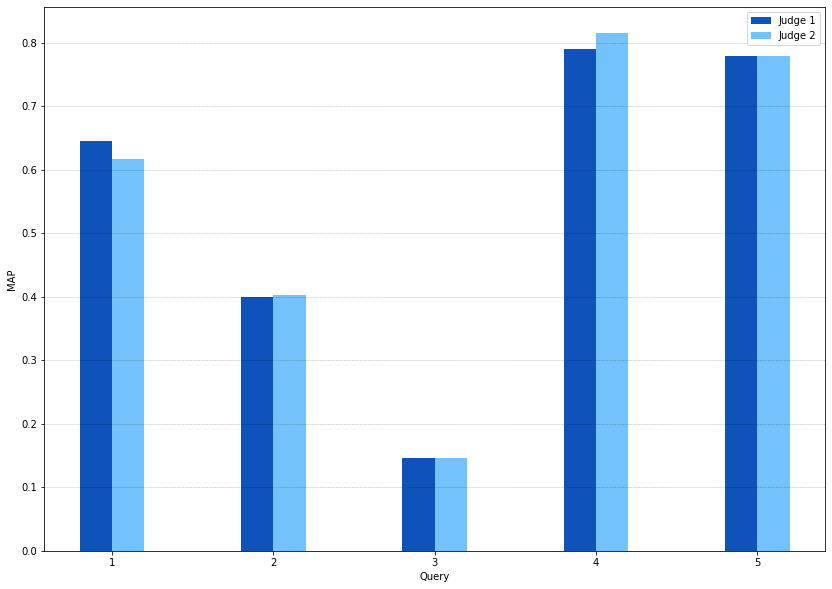

Cohen's Kappa: 0.6323529411764705


In [29]:
def cohen(judge1, judge2):
    agree = 0
    disagree = 0
    total_nonrelevant = 0
    total_relevant = 0
    number_of_documents = len(judge1)
    for i in range(number_of_documents):
        if judge1[i] == judge2[i]:
            agree += 1
        else:
            disagree += 1
            
        if judge1[i] == 0:
            total_nonrelevant += 1
        else:
            total_relevant += 1
        
        if judge2[i] == 0:
            total_nonrelevant += 1
        else:
            total_relevant += 1
        
    PA = agree / number_of_documents
    P_relevant = total_relevant / (2 * number_of_documents)
    P_nonrelevant = total_nonrelevant / (2 * number_of_documents)
    PE = P_relevant**2 + P_nonrelevant**2 
    
    kappa = (PA - PE) / (1 - PE)
    return kappa

def MAP_system(documents, numRel):
    documents = list(documents)
    precision = 0
    count = 0
    for i in range(len(documents)):
        if documents[i] == 'R':
            count += 1
            precision += count / (i+1)
    return precision / numRel



MAP_q1j1 = MAP_system('RRRRRNNRNR', 10)
MAP_q2j1 = MAP_system('RNRNRNRNRR', 10)
MAP_q3j1 = MAP_system('NNNRNRRNRN', 10)
MAP_q4j1 = MAP_system('RRNRRRRRRR', 10)
MAP_q5j1 = MAP_system('RRRRRRRNNR', 10)

MAP_q1j2 = MAP_system('RRRRNNRRNR', 10)
MAP_q2j2 = MAP_system('RNRNNRRRRN', 10)
MAP_q3j2 = MAP_system('NNNRNRRNRN', 10)
MAP_q4j2 = MAP_system('RRRNRRRRRR', 10)
MAP_q5j2 = MAP_system('RRRRRRRNNR', 10)

Map_judge1 = [MAP_q1j1, MAP_q2j1, MAP_q3j1, MAP_q4j1, MAP_q5j1]
Map_judge2 = [MAP_q1j2, MAP_q2j2, MAP_q3j2, MAP_q4j2, MAP_q5j2]
x1 = [0.9, 1.9, 2.9, 3.9, 4.9]
x2 = [1.1, 2.1, 3.1, 4.1, 5.1]


plt.figure(figsize=(14,10))
ax = plt.subplot(111)
ax.bar(x1, Map_judge1, width=0.2, color='#0F52BA', align='center', label="Judge 1")
ax.bar(x2, Map_judge2, width=0.2, color='#73C2FB', align='center', label="Judge 2")
ax.set_xlabel('Query')
ax.set_ylabel('MAP')
ax.legend()
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

plt.show()

N = 0
R = 1
j1 = [R,R,R,R,R,N,N,R,N,R,R,N,R,N,R,N,R,N,R,R,N,N,N,R,N,R,R,N,R,N,R,R,N,R,R,R,R,R,R,R,R,R,R,R,R,R,R,N,N,R]
j2 = [R,R,R,R,N,N,R,R,N,R,R,N,R,N,N,R,R,R,R,N,N,N,N,R,N,R,R,N,R,N,R,R,R,N,R,R,R,R,R,R,R,R,R,R,R,R,R,N,N,R]
print("Cohen's Kappa:", cohen(j1, j2 ))

## Demo

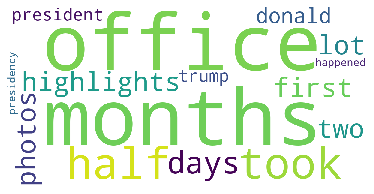

Box(children=(Box(children=(Label(value='Title'), Text(value='Animated map shows every nuclear-bomb explosion …

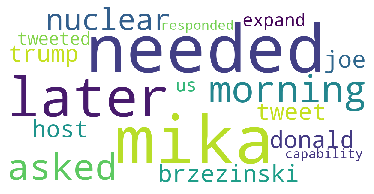

Box(children=(Box(children=(Label(value='Title'), Text(value='This app will send you alerts when Donald Trump …

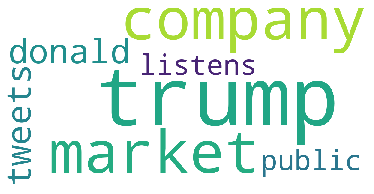

Box(children=(Box(children=(Label(value='Title'), Text(value='Poll: Trump Leads in Top Battleground Counties i…

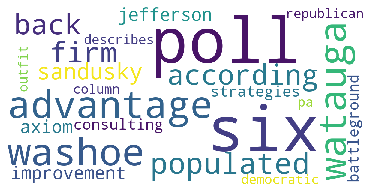

Box(children=(Box(children=(Label(value='Title'), Text(value='Trump paraded raw steaks and assorted ’Trump’ pr…

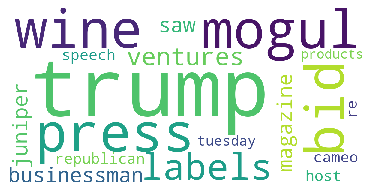

Box(children=(Box(children=(Label(value='Title'), Text(value='Trump isn’t adjusting well to life in the White …

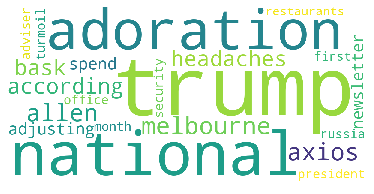

Box(children=(Box(children=(Label(value='Title'), Text(value='Donald Trump Lifts Ban on Blacklisted Media Outl…

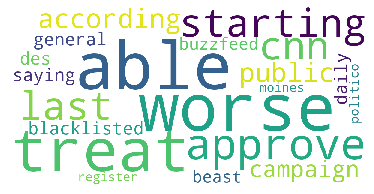

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


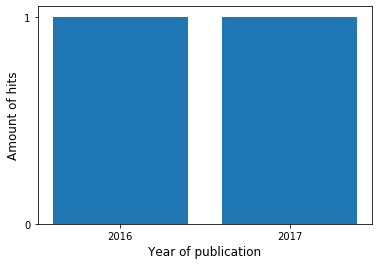

Text(value='trump', description='Query')

Accordion(children=(SelectionRangeSlider(description='Years', index=(12, 18), options=(2000, 2001, 2002, 2003,…

Button(description='Search!', style=ButtonStyle())

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 648x648 with 1 Axes>', 'i…

In [32]:
query_interface()

## Overall evalatuation

All in all we are pleased with the results, the articles we retrieve seem relevant. The thing we would like to improve is to be able to filter on mutliple newspapers instead of just one.